In [1]:
import json
import gzip
import numpy as np
import pandas as pd
from pathlib import Path
from distutils.log import warn
from tqdm.notebook import tqdm

from pymatgen.core import Composition, Structure
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

tqdm.pandas()

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import nfp
from nfp import custom_objects
from nfp.layers import RBFExpansion

2025-05-24 05:54:37.744756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 05:54:42.902100: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jlaw/.conda-envs/crystals/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of l

In [3]:
import sys
sys.path.append("/projects/complexmat/GROUP/projects/nsf-zintl/zintl_atlas/UBEM_ML_model")
from preprocess import preprocessor

/home/jlaw/.conda-envs/crystals/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# since package versions may be important
print(f"{pd.__version__ = }")
print(f"{np.__version__ = }")
print(f"{tf.__version__ = }")
print(f"{nfp.__version__ = }")

pd.__version__ = '1.5.3'
np.__version__ = '1.26.4'
tf.__version__ = '2.10.0'
nfp.__version__ = '0.3.12'


In [5]:
# Not sure which variable pymatgen uses for its version,
# so print it with pip
!pip show pymatgen

Name: pymatgen
Version: 2024.2.8
Summary: Python Materials Genomics is a robust materials analysis code that defines core object representations for structures and molecules with support for many electronic structure codes. It is currently the core analysis code powering the Materials Project (https://materialsproject.org).
Home-page: https://pymatgen.org
Author: Pymatgen Development Team
Author-email: ongsp@ucsd.edu
License: MIT
Location: /home/jlaw/.conda-envs/crystals/lib/python3.10/site-packages
Requires: joblib, matplotlib, monty, networkx, numpy, palettable, pandas, plotly, pybtex, requests, ruamel.yaml, scipy, spglib, sympy, tabulate, tqdm, uncertainties
Required-by: matminer


## Predict the total energy
- This model has been trained with the ICSD, fully relaxed, and volume-relaxed datasets
- This means it will predict the total energy of a structure in its given state
  - if the structure is unrelaxed, the energy predicted will be an upper-bound for the energy after relaxation

In [6]:
# Load the tensorflow model for predicting the total energy of a given structure
# If you haven't already, you'll need to download the model using download.sh (see README.md)
energy_model_file = Path("/projects/complexmat/GROUP/projects/nsf-zintl/zintl_atlas/UBEM_ML_model/output/best_model.hdf5")
print(f"loading {energy_model_file}")
energy_model = tf.keras.models.load_model(energy_model_file,
                                          custom_objects={**custom_objects,
                                                          **{'RBFExpansion': RBFExpansion}})

loading /projects/complexmat/GROUP/projects/nsf-zintl/zintl_atlas/UBEM_ML_model/output/best_model.hdf5


2025-05-24 05:55:02.074748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 05:55:02.577733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 40602 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:23:00.0, compute capability: 8.9
2025-05-24 05:55:02.587782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 42955 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:89:00.0, compute capability: 8.9


Here's an example of how to predict the energy for a structure

In [84]:
# Here we define some convenience functions for preprocessing structures and generating predictions
def preprocess_structure(structure):
    inputs = preprocessor(structure)
    # scale structures to a minimum of 1A interatomic distance
    min_distance = inputs["distance"].min()
    if np.isclose(min_distance, 0):
        warn(f"Error with {row.id}")
        return None

    scale_factor = 1.0 / inputs["distance"].min()
    print(scale_factor)
    inputs["distance"] *= scale_factor
    return inputs


def build_dataset(structures, batch_size=8):
    dataset = tf.data.Dataset.from_generator(
        lambda: (preprocess_structure(s) for s in structures),
        output_signature=(preprocessor.output_signature),
        ).padded_batch(
            batch_size=batch_size,
            padding_values=(preprocessor.padding_values),
        )
    return dataset


def predict_energy(energy_model, structures):
    dataset = build_dataset(structures)
    predicted_energy = energy_model.predict(dataset)
    return predicted_energy.flatten()

In [88]:
# Load a structure from file. 
base_dir = Path("/projects/complexmat/GROUP/projects/nsf-zintl/zintl_atlas/")
decorations_dir = base_dir / "decorations"
structure_file = base_dir / "UBEM_ML_model/poscars/POSCAR_a5d1_26_P5Tl1_icsd_015021_As_Ga"
structure = Structure.from_file(structure_file)
structure

Structure Summary
Lattice
    abc : 7.145171867736691 7.653457179720004 13.392914569718982
 angles : 90.0 90.0 90.0
 volume : 732.3951082353593
      A : 7.145171867736691 0.0 0.0
      B : 5e-16 7.653457179720004 0.0
      C : 8e-16 8e-16 13.392914569718982
    pbc : True True True
PeriodicSite: As (1.794, 6.011, 1.512) [0.2511, 0.7854, 0.1129]
PeriodicSite: As (5.351, 6.011, 1.512) [0.7489, 0.7854, 0.1129]
PeriodicSite: As (5.351, 1.642, 8.209) [0.7489, 0.2146, 0.6129]
PeriodicSite: As (1.794, 1.642, 8.209) [0.2511, 0.2146, 0.6129]
PeriodicSite: As (1.793, 4.564, 3.506) [0.251, 0.5963, 0.2618]
PeriodicSite: As (5.352, 4.564, 3.506) [0.749, 0.5963, 0.2618]
PeriodicSite: As (5.352, 3.09, 10.2) [0.749, 0.4037, 0.7618]
PeriodicSite: As (1.793, 3.09, 10.2) [0.251, 0.4037, 0.7618]
PeriodicSite: As (3.749e-16, 2.95, 3.051) [0.0, 0.3854, 0.2278]
PeriodicSite: As (8.895e-16, 4.704, 9.747) [0.0, 0.6146, 0.7278]
PeriodicSite: As (3.689e-16, 1.312, 4.741) [0.0, 0.1714, 0.354]
PeriodicSite: As (1

In [89]:
predicted_energies = predict_energy(energy_model, [structure])
predicted_energies

0.4256216197676258
1/1 [==============================] - 0s 117ms/step


array([-4.1921277], dtype=float32)

In [87]:
predicted_energies = predict_energy(energy_model, [structure])
predicted_energies

0.34436980172913
1/1 [==============================] - 0s 110ms/step


array([-3.5346313], dtype=float32)

In [10]:
from glob import glob
# from tqdm.notebook import tqdm

In [11]:
# now load all the structures and make all the predictions
structures = {}
for s_file in glob(str(decorations_dir / "*/*/*/POSCAR*")):
    s_file = Path(s_file)
    structure = Structure.from_file(s_file, primitive=True)
    structures[s_file.name] = structure

print(len(structures))

90856


In [12]:
predicted_energies = predict_energy(energy_model, list(structures.values())[:10])
predicted_energies

2/2 [==============================] - 0s 66ms/step


array([-4.302996 , -4.0243716, -5.312325 , -4.000423 , -4.379902 ,
       -4.5538793, -4.0985417, -3.9308417, -4.218911 , -4.132237 ],
      dtype=float32)

In [13]:
df = pd.DataFrame([list(structures.keys())[:10], predicted_energies]).T
df.columns = ["structure", "predicted_energy"]
df

,structure,predicted_energy
0,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996
1,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.024372
2,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Si,-5.312325
3,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Ge,-4.000423
4,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Sn,-4.379902
5,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Ge,-4.553879
6,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Si,-4.098542
7,POSCAR_a2e1_205_P2Si1_icsd_024333_Bi_Sn,-3.930842
8,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Si,-4.218911
9,POSCAR_a2e1_205_P2Si1_icsd_024333_As_Pb,-4.132237


In [14]:
# I ran the predictions separately. Load them here
out_file = "predicted_energies.csv"
df = pd.read_csv(out_file, index_col=0)
print(len(df))
df.head(2)

90856


,structure,predicted_energy
0,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996
1,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.024372


<Axes: ylabel='Frequency'>

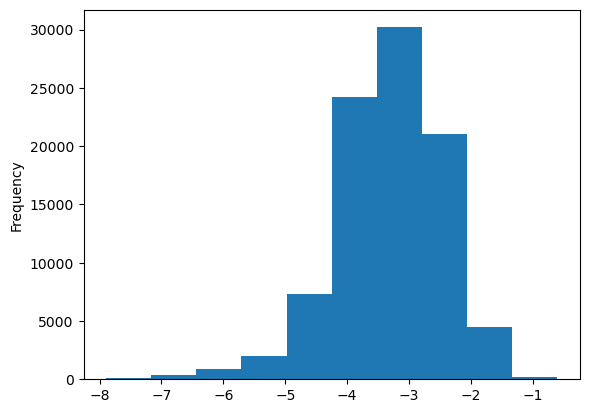

In [15]:
df.predicted_energy.plot.hist(bins=30)

## Decomposition Energy
- Build the convex hull and compute the predicted decomposition energy for this structure
- We can also compute all of the "sub-rewards" we're interested in
- To compute the self-consistent decomposition energy, we would need all the DFT-relaxed energies we have, as well as the lowest predicted energy for each relevant composition

In [24]:
from src.ehull import setup_competing_phases, convex_hull_stability
from src.crystal_reward import StructureRewardBattInterface

In [18]:
# first load the competing phases from NREL MatDB
competing_phases_file = "inputs/competing_phases.csv"
competing_phases = setup_competing_phases(competing_phases_file)

Reading inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
	12682 entries


In [19]:
# The rewarder calculates all the sub-rewards (e.g. decomposition energy, conducting ion %)
# and combines them into a single reward value
rewarder = StructureRewardBattInterface(competing_phases)

In [13]:
# now compute the reward of the structure
comp = structure.composition
energyperatom = predicted_energies[0]
reward, info = rewarder.compute_reward(comp, energyperatom)
comp, reward, info

(Comp: Li1 Sc2 F7,
 0.8275238356399739,
 {'predicted_energy': -6.284776,
  'oxidation': -5,
  'reduction': -0.8864,
  'stability_window': 4.1136,
  'decomp_energy': -1.7769,
  'cond_ion_frac': 0.1})

In [41]:
competing_phases

0                 PDEntry : Ag1 with energy = -0.7900
1                 PDEntry : Al1 with energy = -3.2700
2                 PDEntry : As1 with energy = -4.9500
3                 PDEntry : Au1 with energy = -1.9600
4                  PDEntry : B1 with energy = -6.7300
                             ...                     
12737    PDEntry : Sn2 Sr1 Zn2 with energy = -14.0339
12738        PDEntry : Sn2 Ta1 with energy = -17.2825
12739        PDEntry : Sn2 Zr1 with energy = -15.8536
12740    PDEntry : Sn3 Zn1 Zr5 with energy = -51.1964
12741         PDEntry : Li2 O1 with energy = -14.3010
Name: 0, Length: 12742, dtype: object

In [30]:
from tqdm import tqdm

In [43]:
# compute the decomposition energies of the structures
decomp_energies = {}
for s_id, structure in tqdm(structures.items()):
    energyperatom = df[df.structure == s_id].predicted_energy.values[0]
    try:
        decomp_energy, stability_window = convex_hull_stability(
                        structure.composition,
                        energyperatom,
                        competing_phases,
                )
        decomp_energies[s_id] = decomp_energy
    except ValueError as e:
        print(f"ValueError for {s_id}: {e}")
        decomp_energies[s_id] = np.nan
    # reward, info = rewarder.compute_reward(comp, energyperatom)
    # decomp_energies[s_id] = info['decomp_energy']

df = df.set_index('structure')
df['decomp_energy'] = decomp_energies
df.head(2)

,predicted_energy,decomp_energy
structure,,
POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996,0.573989
POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.024372,0.067970


In [35]:
df2 = df.dropna(subset="decomp_energy")
print(len(df2))
out_file = "predicted_decomp_energy.csv"
df2.to_csv(out_file)

72696


### UPDATE: cacluate the 'self-consistent' decomposition energy by including the lowest predicted energy for each composition

In [53]:
df2["composition"] = df2.structure.apply(lambda s: ''.join(sorted(structures[s].composition.reduced_composition.formula.split(' '))))
df2.head(2)

,structure,predicted_energy,decomp_energy,composition
0,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996,0.573989,P2Pb1
1,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.024372,0.067970,Sb2Sn1


<Axes: ylabel='Frequency'>

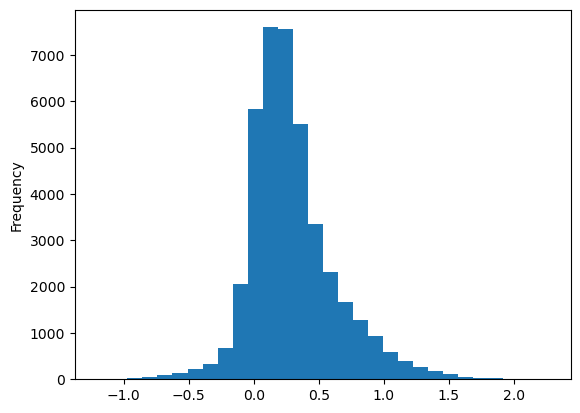

In [58]:
comps_min_energy = df2[["composition", "decomp_energy"]].groupby("composition").min()
comps_min_energy.decomp_energy.plot.hist(bins=30)

In [59]:
comps_min_energy = comps_min_energy.reset_index()
comps_min_energy

,composition,decomp_energy
0,Al1As1,-0.406064
1,Al1As11Ba14,-0.040416
2,Al1As11Be14,0.471023
3,Al1As11Ca14,-0.061446
4,Al1As11Cd14,0.201954
...,...,...
41279,Sb9Sr9Zn4,-0.082479
41280,Sb9Tl1Zn11,0.331916
41281,Sb9Tl4Zn7,0.826289
41282,Sb9Zn13,0.216366


In [60]:
comps_min_energy["predicted_energy"] = comps_min_energy.apply(lambda row: df2[(df2.composition == row.composition) & (df2.decomp_energy == row.decomp_energy)].predicted_energy.values[0], axis=1)
comps_min_energy

,composition,decomp_energy,predicted_energy
0,Al1As1,-0.406064,-4.516064
1,Al1As11Ba14,-0.040416,-4.152862
2,Al1As11Be14,0.471023,-3.677419
3,Al1As11Ca14,-0.061446,-4.348226
4,Al1As11Cd14,0.201954,-2.535480
...,...,...,...
41279,Sb9Sr9Zn4,-0.082479,-3.446136
41280,Sb9Tl1Zn11,0.331916,-2.225410
41281,Sb9Tl4Zn7,0.826289,-1.970948
41282,Sb9Zn13,0.216366,-2.210576


In [75]:
comps_min_energy["structure"] = comps_min_energy.apply(lambda row: df2[(df2.composition == row.composition) & (df2.decomp_energy == row.decomp_energy)].structure.values[0], axis=1)

In [67]:
energy_col = "predicted_energy"
comp_col = "composition"
comps_min_energy['energy'] = (
    comps_min_energy[energy_col] *
    comps_min_energy[comp_col].apply(lambda x: Composition(x).num_atoms)
)
# convert the dataframe to a list of PDEntries used to create the convex hull
pd_entries = comps_min_energy.apply(
    lambda row: PDEntry(Composition(row[comp_col]),
                        row.energy),
    axis=1
)
print(f"\t{len(pd_entries)} entries")

	41284 entries


In [68]:
len(competing_phases)

12742

In [71]:
len(pd_entries)

41284

In [72]:
competing_phases_wpred = list(competing_phases) + list(pd_entries)
print(len(competing_phases_wpred))

54026


In [73]:
df2.head(2)

,structure,predicted_energy,decomp_energy,composition
0,POSCAR_a2e1_205_P2Si1_icsd_024333_P_Pb,-4.302996,0.573989,P2Pb1
1,POSCAR_a2e1_205_P2Si1_icsd_024333_Sb_Sn,-4.024372,0.067970,Sb2Sn1


In [ ]:
# compute the decomposition energies of the structures
decomp_energies = {}
for s_id, energyperatom in tqdm(df2[["structure", "predicted_energy"]].values):
    structure = structures[s_id]
    try:
        decomp_energy, stability_window = convex_hull_stability(
                        structure.composition,
                        energyperatom,
                        competing_phases_wpred,
                )
        decomp_energies[s_id] = decomp_energy
    except ValueError as e:
        print(f"ValueError for {s_id}: {e}")
        decomp_energies[s_id] = np.nan
    # reward, info = rewarder.compute_reward(comp, energyperatom)
    # decomp_energies[s_id] = info['decomp_energy']

In [77]:
df_sc = comps_min_energy.copy()
df_sc.drop(columns="energy", inplace=True)
df_sc.head(2)

,composition,decomp_energy,predicted_energy,structure
0,Al1As1,-0.406064,-4.516064,POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al
1,Al1As11Ba14,-0.040416,-4.152862,POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As...


In [78]:
df_sc = df_sc.set_index('structure')
df_sc['decomp_energy'] = decomp_energies
df_sc.head(2)

,composition,decomp_energy,predicted_energy
structure,,,
POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-0.406064,-4.516064
POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As_Ba_Al,Al1As11Ba14,0.050697,-4.152862


In [80]:
df_sc[df_sc.decomp_energy < 0.05]

,composition,decomp_energy,predicted_energy
structure,,,
POSCAR_a1d1_186_In1Sb1_icsd_190430_As_Al,Al1As1,-0.406064,-4.516064
POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As_Ca_Al,Al1As11Ca14,-0.026320,-4.348226
POSCAR_a11c14d1_142_Al1Ca14Sb11_icsd_033266_As_Sr_Al,Al1As11Sr14,0.035193,-4.088831
POSCAR_a2b2d1_14_As2Ga1K2_icsd_300142_Cs_As_Al,Al1As2Cs2,0.018773,-3.406930
POSCAR_a2b1b2d1_72_Al1As2K2Na1_icsd_073280_K_Cs_As_Al,Al1As2Cs2K1,0.011740,-3.107215
...,...,...,...
POSCAR_a8c11e2_139_Bi8Sn2Yb11_icsd_263134_Sr_Sb_Sn,Sb8Sn2Sr11,0.024776,-3.772164
POSCAR_a14c11c8_12_Ba11Bi14Cd8_icsd_240338_Sb_Zn_Sr,Sb8Sr11Zn14,-0.108760,-2.677696
POSCAR_a9c10c2_136_Ca10Mg2Sb9_icsd_171162_Sb_Sr_Sn,Sb9Sn2Sr10,0.020709,-3.829318


In [81]:
print(len(df_sc[df_sc.decomp_energy < 0]))
df_sc.to_csv("predicted_decomp_energy_self_consisitent.csv")

1685
